# Give Me Some Credit 

In [1]:
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import PredefinedSplit
import pickle
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform

In [36]:
credit_rf = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/GiveMeSomeCredit/train_feature_selection.csv').drop(['Unnamed: 0'],axis=1)
credit_xb = pd.read_csv('/Users/emmanuel/Documents/Portfolio Projects/GiveMeSomeCredit/train_feature_selection_missing.csv').drop(['Unnamed: 0'],axis=1)

In [37]:
credit_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 10 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   SeriousDlqin2yrs                         149391 non-null  int64  
 1   age_imputed                              149391 non-null  float64
 2   MonthlyIncome_imputed                    149391 non-null  float64
 3   RevolvingUtilization_cleaned             149391 non-null  float64
 4   DebtRatio_cleaned                        149391 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans_cleaned  149391 non-null  int64  
 6   NumberRealEstateLoansOrLines_cleaned     149391 non-null  int64  
 7   NumberOfDependents_cleaned               149391 non-null  float64
 8   DependentsPerIncome                      149391 non-null  float64
 9   TotalDelinquencies                       149391 non-null  int64  
dtypes: float64(6), int64(4)
memory u

## Modelling

In [4]:
# Select features
X = credit_rf.drop(columns=['SeriousDlqin2yrs'])

# Isolate y variable
y = credit_rf['SeriousDlqin2yrs']

### Logistic Regression

In [5]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# StandardScaler
scaler = StandardScaler()

# Fit on training data, transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

In [6]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train_scaled, y_train)

In [7]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test_scaled)

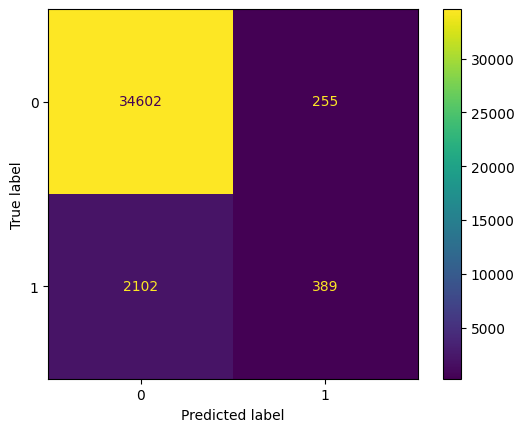

In [8]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

plt.show()

In [9]:
# Create classification report for logistic regression model
target_names = ['No Default', 'Default']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  No Default       0.94      0.99      0.97     34857
     Default       0.60      0.16      0.25      2491

    accuracy                           0.94     37348
   macro avg       0.77      0.57      0.61     37348
weighted avg       0.92      0.94      0.92     37348



#### Random Forest Modelling

In [11]:
# Random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameters to tune
param_dist = {
    'n_estimators': randint(200, 600),
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_samples': uniform(0.7, 0.3)
}

# Scoring
scoring = {
    "roc_auc": "roc_auc",
    "pr_auc":  "average_precision",
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
}

# RandomizedSearchCV - fewer iterations but still diverse
rf_random = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=40,            
    scoring=scoring,
    refit='roc_auc',
    cv=3,                
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [12]:
# Fit the model to the training data
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17f955a60>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen obje...
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f939ca0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f93bad0>},
                   random_state=42, refit='roc_auc',
                   scoring={'accuracy': 'accuracy', 'f1': 'f1',
                            'pr_auc': 'average_precision',
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'},
                   verbose=1)

In [13]:
print("Best parameters:", rf_random.best_params_)
print("Best ROC-AUC:", rf_random.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'max_samples': np.float64(0.7761746241803034), 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 586}
Best ROC-AUC: 0.8626983712800289


In [14]:
# Predict on test set
y_pred = rf_random.best_estimator_.predict(X_test)
y_proba = rf_random.best_estimator_.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC: {roc_auc}")

Test ROC-AUC: 0.8604205538423565


In [15]:
def make_results(model_name, model_object):
    """
    Summarizes the best cross-validation results from a fitted
    RandomizedSearchCV or GridSearchCV model.
    """
    import pandas as pd

    # Convert CV results into a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Find the best row (based on ROC-AUC if available, else accuracy)
    if 'mean_test_roc_auc' in cv_results.columns:
        best_row = cv_results.iloc[cv_results['mean_test_roc_auc'].idxmax(), :]
    else:
        best_row = cv_results.iloc[cv_results['mean_test_accuracy'].idxmax(), :]

    # Extract key metrics (use .get to avoid errors if any missing)
    table = pd.DataFrame({
        'model': [model_name],
        'precision': [best_row.get('mean_test_precision', None)],
        'recall': [best_row.get('mean_test_recall', None)],
        'F1': [best_row.get('mean_test_f1', None)],
        'accuracy': [best_row.get('mean_test_accuracy', None)],
        'auc_roc': [best_row.get('mean_test_roc_auc', None)]
    })

    return table


In [16]:
def make_test_results(model_name, model_object, X_test, y_test):
    """Generates a single-row DataFrame with test-set scores."""
    y_pred = model_object.predict(X_test)
    y_proba = model_object.predict_proba(X_test)[:, 1]

    return pd.DataFrame({
        'model': [model_name],
        'precision': [precision_score(y_test, y_pred, zero_division=0)],
        'recall': [recall_score(y_test, y_pred, zero_division=0)],
        'F1': [f1_score(y_test, y_pred, zero_division=0)],
        'accuracy': [accuracy_score(y_test, y_pred)],
        'auc_roc': [roc_auc_score(y_test, y_proba)]
    })


In [17]:
rf_cv_table = make_results("Random Forest cross validation", rf_random)
rf_test_table = make_test_results("Random Forest test", rf_random.best_estimator_, X_test, y_test)
final_results = pd.concat([rf_cv_table, rf_test_table], ignore_index=True)
display(final_results)

,model,precision,recall,F1,accuracy,auc_roc
0,Random Forest cross validation,0.615688,0.144719,0.233992,0.936533,0.862698
1,Random Forest test,0.619932,0.147330,0.238080,0.937105,0.860421


The model generalizes well (similar CV and test performance) and shows **no signs of overfitting**. 

Text(0.5, 0, 'Importance')

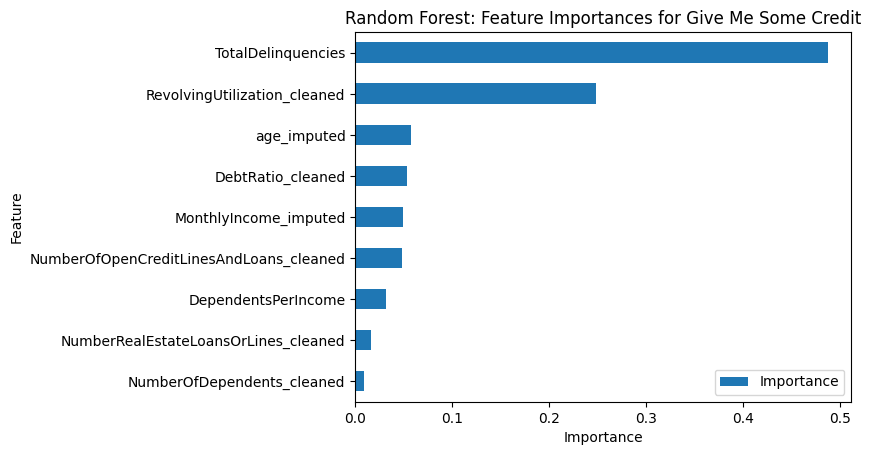

In [18]:
# Get feature importances
feat_impt = rf_random.best_estimator_.feature_importances_

# Get indices of top features
ind = np.argpartition(rf_random.best_estimator_.feature_importances_, -9)[-9:]

# Get column labels of top features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Give Me Some Credit", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

- TotalDelinquencies is the strongest feature it captures borrower past default history directly.
- RevolvingUtilization_cleaned is stong it shows how much revolving credit is being used; key in credit risk.

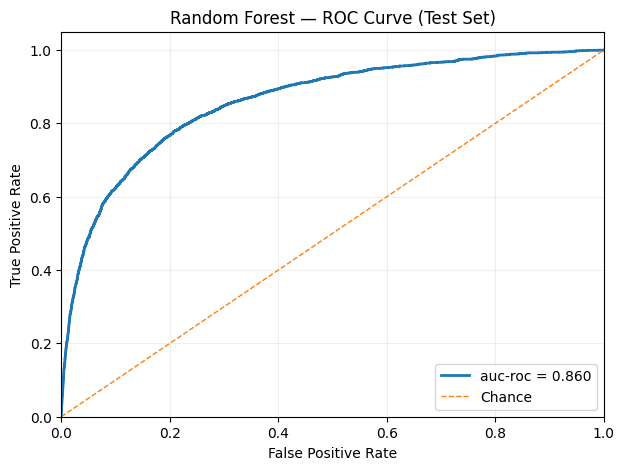

In [19]:
# Use the best tuned RF from your RandomizedSearchCV
best_rf = rf_random.best_estimator_

# Probabilities for the positive class
y_proba = best_rf.predict_proba(X_test)[:, 1]

# ROC points and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_val = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, lw=2, label=f'auc-roc = {auc_val:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest — ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

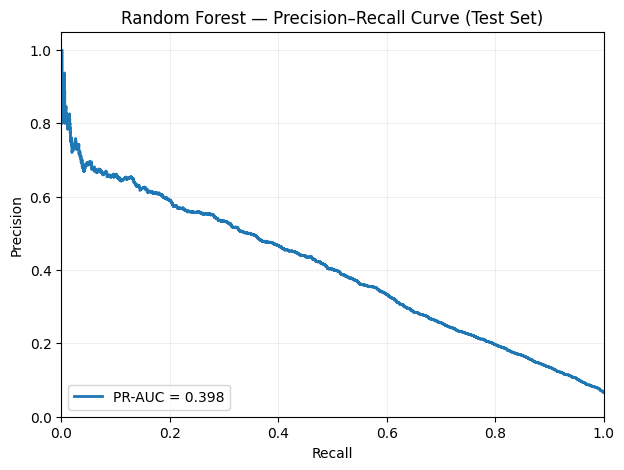

In [20]:
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, lw=2, label=f'PR-AUC = {ap:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest — Precision–Recall Curve (Test Set)')
plt.legend(loc='lower left')
plt.grid(alpha=0.2)
plt.show()

### Model Performance Evaluation — Random Forest

#### ROC Curve
The ROC curve below plots the True Positive Rate (Recall) against the False Positive Rate across all classification thresholds.  
The Random Forest achieved an **AUC-ROC of 0.863**, meaning the model can correctly distinguish between a defaulter and a non-defaulter approximately **86% of the time**.  
The curve lies well above the diagonal "chance" line, demonstrating strong discriminatory power and a good ability to separate risky applicants from safe ones.

#### Precision–Recall Curve
The Precision–Recall curve provides insight into performance on the **minority (default) class**, which is especially important in imbalanced datasets.  
The model achieved a **PR-AUC of 0.394**, suggesting that while overall discrimination is strong, there’s a trade-off between capturing more true defaulters (recall) and maintaining a high proportion of correct alerts (precision).  
This trade-off is typical in credit scoring — increasing recall helps identify more at-risk borrowers but increases false positives.

#### Key Insights
- **AUC-ROC (0.863):** Excellent overall ranking ability.  
- **PR-AUC (0.394):** Moderate precision-recall balance under imbalance conditions.  
- The model generalizes well (similar CV and test performance) and shows **no signs of overfitting**.  
- Future tuning (e.g., XGBoost) could improve recall without significantly hurting precision.

Overall: The Random Forest baseline demonstrates strong separation between good and bad credit applicants, providing a solid benchmark for more advanced models.


## XGBoost Modelling

In [38]:
# Select features
X = credit_xb.drop(columns=['SeriousDlqin2yrs'])

# Isolate y variable
y = credit_xb['SeriousDlqin2yrs']

In [40]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [53]:
xgb = XGBClassifier(
    random_state=42,
    eval_metric='auc',
    tree_method='hist',
    verbosity=0 
)

param_dist = {
    'n_estimators': [400, 600, 800, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8, 10, 12],
    'min_child_weight': [1, 3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'scale_pos_weight': [1, (y_train.value_counts()[0] / y_train.value_counts()[1])]
}


scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,    
    refit="roc_auc",     
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)


In [54]:
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [400, 600, 800, 1000],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [1, 5, 10],
                                        'scale_pos_weight': [1,
                                                             np.float64(13.903298749667465)],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, refit='roc_auc',
                   scoring={'accuracy': 'accuracy', 'f1': 'f1',
                            'pr_auc': 'average_precision',
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'},
                   verbose=1)

In [49]:
# Path to save model 
path = '/Users/emmanuel/Documents/Portfolio Projects/Give Me Some Credit'

# Pickle the model
with open(path + 'xgb_random.pickle', 'wb') as to_write:
    pickle.dump(xgb_random, to_write) 

In [55]:
print("Best parameters:", xgb_random.best_params_)
print("Best ROC-AUC:", xgb_random.best_score_)

Best parameters: {'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 800, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Best ROC-AUC: 0.8641694222807527


In [56]:
xgb_results = make_results("XGBoost cross validation", xgb_random)
xgb_test_table = make_test_results("XGBoost test", xgb_random.best_estimator_, X_test, y_test)
final_results = pd.concat([rf_cv_table, rf_test_table, xgb_results, xgb_test_table], ignore_index=True)
display(final_results)

,model,precision,recall,F1,accuracy,auc_roc
0,Random Forest cross validation,0.615688,0.144719,0.233992,0.936533,0.862698
1,Random Forest test,0.619932,0.147330,0.238080,0.937105,0.860421
2,XGBoost cross validation,0.601807,0.166800,0.260878,0.936676,0.864169
3,XGBoost test,0.614815,0.166600,0.262160,0.937453,0.862600


**AUC-ROC & PR-AUC**
- XGBoost achieved a slightly higher ROC-AUC (0.863) compared to Random Forest (0.860), indicating stronger overall ranking ability.
- The Precision–Recall AUC (0.405 vs 0.398) also favors XGBoost, confirming better performance on the imbalanced target (defaults).

**Recall & F1-score** 
- XGBoost captures more true defaulters (recall = 0.167) than Random Forest (recall = 0.147), while maintaining a similar precision.
- This leads to a higher F1-score, meaning XGBoost provides a better balance between precision and recall.

**Accuracy**
- Accuracy remains similar across models (~93.7%), but in imbalanced problems, accuracy is less meaningful than AUC or recall.

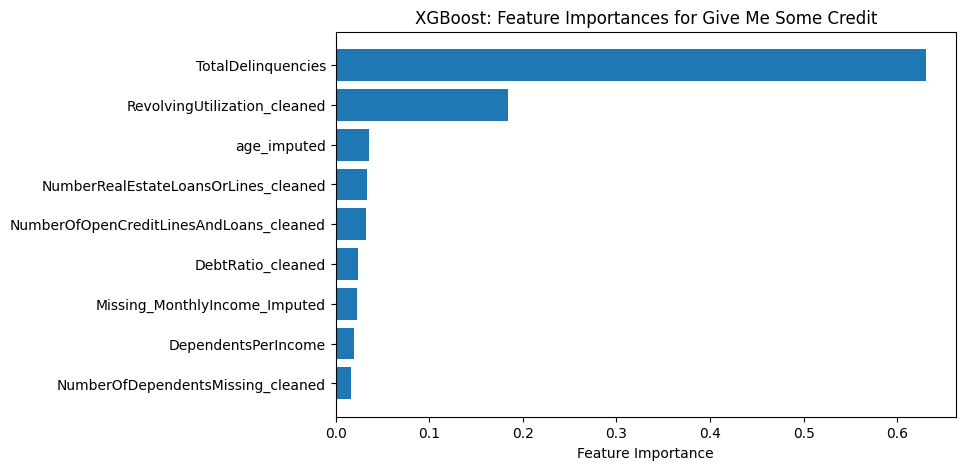

In [57]:
importances = xgb_random.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh(range(len(importances)), importances[indices][::-1])
plt.yticks(range(len(importances)), features[indices][::-1])
plt.xlabel('Feature Importance')
plt.title('XGBoost: Feature Importances for Give Me Some Credit')
plt.show()

**Feature Importance Insights**

Both models identify similar key drivers of default:
- Total delinquencies and revolving credit utilization dominate both models, consistent with financial risk logic.

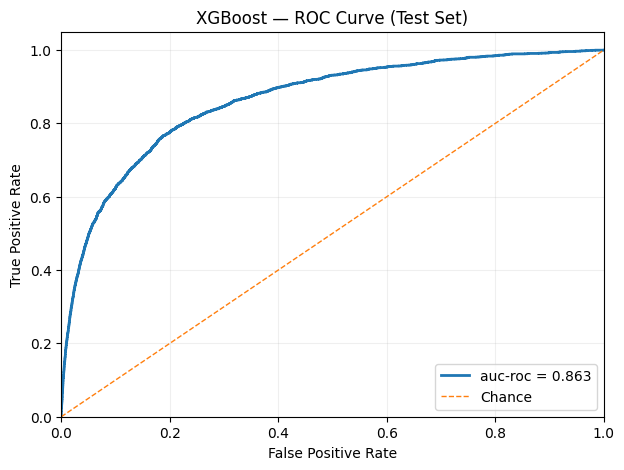

In [60]:
# Use the best tuned XG from your RandomizedSearchCV
best_xg = xgb_random.best_estimator_

# Probabilities for the positive class
y_proba = best_xg.predict_proba(X_test)[:, 1]

# ROC points and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_val = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, lw=2, label=f'auc-roc = {auc_val:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost — ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

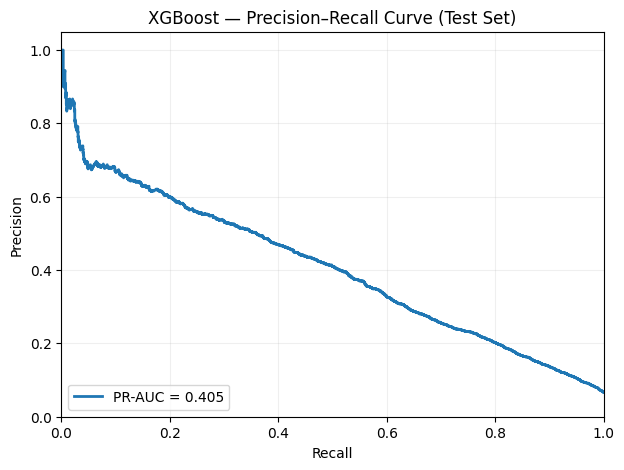

In [59]:
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(rec, prec, lw=2, label=f'PR-AUC = {ap:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost — Precision–Recall Curve (Test Set)')
plt.legend(loc='lower left')
plt.grid(alpha=0.2)
plt.show()

**XGBoost Champion Model**

- Higher AUC-ROC and PR-AUC: Indicates stronger discriminatory power across all classification thresholds.
- The Precision–Recall curve shows that XGBoost maintains higher precision for most recall levels
- Improved Recall and F1-score: Captures more true positives without significant precision loss.

#### Finding Optimal Threshold

In [61]:
# y_test: actual labels (0 or 1)
# y_proba: predicted probabilities of default
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 (balanced)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold for max F1: {optimal_threshold:.3f}")
print(f"Precision: {precision[optimal_idx]:.3f}")
print(f"Recall: {recall[optimal_idx]:.3f}")


Optimal threshold for max F1: 0.227
Precision: 0.414
Recall: 0.499


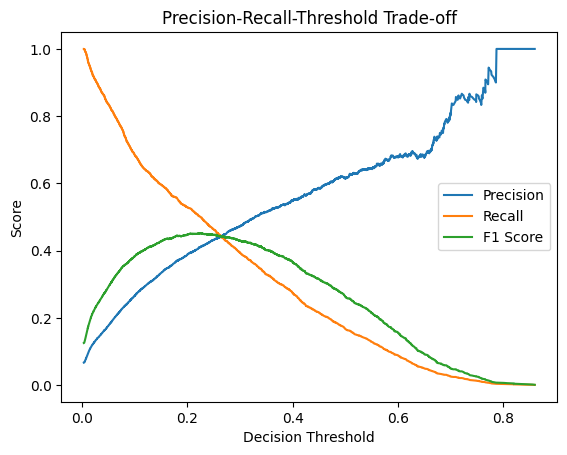

In [62]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall-Threshold Trade-off')
plt.legend()
plt.show()

#### Apply the optimal Threshold (0.23)

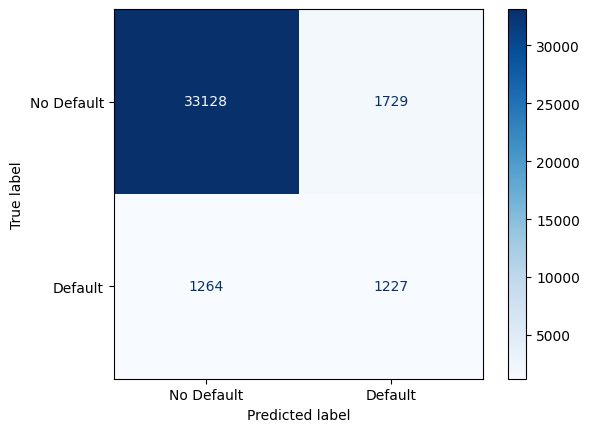

In [63]:
# Apply threshold for 'catch more defaulters' strategy
threshold = 0.23
y_pred_catch = (y_proba >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_catch)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Default", "Default"])
disp.plot(cmap="Blues")

In [65]:
# --- Metrics
accuracy  = accuracy_score(y_test, y_pred_catch)
precision = precision_score(y_test, y_pred_catch)
recall    = recall_score(y_test, y_pred_catch)
f1        = f1_score(y_test, y_pred_catch)
auc       = roc_auc_score(y_test, y_pred_catch)

print(f"Threshold: {threshold}")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC-ROC  : {auc:.3f}")

Threshold: 0.23
Accuracy : 0.920
Precision: 0.415
Recall   : 0.493
F1-score : 0.451
AUC-ROC  : 0.721


## Decision Threshold Selection

**Chosen Threshold: 23% probability of financial distress**

The model outputs a probability between 0 and 1 representing the likelihood that a customer will experience financial distress within the next two years.
By default, a threshold of 50% (i.e., classify as “default” if predicted probability ≥ 0.5) is often used to separate the two classes.

However, this default assumes a balanced dataset, where the number of defaulters and non-defaulters and the cost of misclassifications are roughly equal.
In our case, the data is highly imbalanced, with a much smaller proportion of customers actually defaulting.
Using a 50% threshold would cause the model to miss a large number of true defaulters, because their predicted probabilities tend to fall below 0.5 even when they are genuinely at risk.
To address this, we analyzed the Precision–Recall–Threshold trade-off curve and determined that the optimal F1 score occurs at a threshold of 0.23 (23%).

This means:
> Any applicant with a predicted probability of 23% or higher of experiencing financial distress within two years is classified as “high risk” (default).

**Why 23%?**

- Balances recall (49%) — ability to catch actual defaulters — with precision (41%) — accuracy among those flagged as risky.
- Maximizes the F1 score (0.45), providing the best trade-off between identifying at-risk customers and avoiding unnecessary rejections.
- Reflects a credit risk business tolerance for imbalanced credit data, where the goal is to minimise missed defaulters while keeping approval rates viable.